## imports

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Concatenate, Conv2D, Dropout, GlobalAveragePooling2D, MaxPooling2D, Input, Lambda, add
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

### Scaling Function

In [2]:
def scaling(x, scale):
    return x * scale

### Stem Layer

In [3]:
def stem(inputs):
    x = Conv2D(32, 3, strides=2, padding='valid', use_bias=False) (inputs)
    x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(32, 3, strides=1, padding='valid', use_bias=False) (x)
    x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, strides=1, padding='same', use_bias=False) (x)
    x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = Conv2D(80, 1, strides=1, padding='valid', use_bias=False) (x)
    x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(192, 3, strides=1, padding='valid', use_bias=False) (x)
    x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, 3, strides=2, padding='valid', use_bias=False) (x)
    x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(x)
    x = Activation('relu')(x)
    return x

### Inception-ResNet-A block

In [4]:
def Inception_ResNet_A(x):
    # Branch 0
    branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False) (x)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_0)
    branch_0 = Activation('relu')(branch_0)
    
    # Branch 1
    branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False) (x)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False) (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    
    # Branch 2
    branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False) (x)
    branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_2)
    branch_2 = Activation('relu')(branch_2)
    branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False) (branch_2)
    branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_2)
    branch_2 = Activation('relu')(branch_2)
    branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False) (branch_2)
    branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_2)
    branch_2 = Activation('relu')(branch_2)

    branches = [branch_0, branch_1, branch_2]
    concat = Concatenate(axis=3)(branches)
    conv = Conv2D(256, 1, strides=1, padding='same', use_bias=True) (concat)
    lamd = Lambda(scaling, output_shape=K.int_shape(conv)[1:], arguments={'scale': 0.17})(conv)
    x = add([x, lamd])
    x = Activation('relu')(x)
    
    return x

### Reduction A-block

In [5]:
def Reduction_A(x):
    # Branch 0
    branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False) (x)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_0)
    branch_0 = Activation('relu')(branch_0)
    
    # Branch 1
    branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False) (x)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(192, 3, strides=1, padding='same', use_bias=False) (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False) (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    
    # Pooling branch
    pool = MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, pool]
    x = Concatenate(axis=3)(branches)
    return x

### Inception-ResNet-B block

In [6]:
def Inception_ResNet_B(x):
    # Branch 0
    branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False) (x)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_0)
    branch_0 = Activation('relu')(branch_0)
    
    # Branch 1
    branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False)(x)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False)(branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False)(branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branches = [branch_0, branch_1]
    concat = Concatenate(axis=3)(branches)
    conv = Conv2D(896, 1, strides=1, padding='same', use_bias=True) (concat)
    lambd = Lambda(scaling, output_shape=K.int_shape(conv)[1:], arguments={'scale': 0.1})(conv)
    x = add([x, lambd])
    x = Activation('relu')(x)
    
    return x

### Reduction-B block

In [7]:
def Reduction_B(x):
    # Branch 0
    branch_0 = Conv2D(256, 1, strides=1, padding='same', use_bias=False) (x)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_0)
    branch_0 = Activation('relu')(branch_0)
    branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False) (branch_0)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_0)
    branch_0 = Activation('relu')(branch_0)
    
    # Branch 1
    branch_1 = Conv2D(256, 1, strides=1, padding='same', use_bias=False) (x)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False) (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    
    # Branch 2
    branch_2 = Conv2D(256, 1, strides=1, padding='same', use_bias=False) (x)
    branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_2)
    branch_2 = Activation('relu')(branch_2)
    branch_2 = Conv2D(256, 3, strides=1, padding='same', use_bias=False) (branch_2)
    branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_2)
    branch_2 = Activation('relu')(branch_2)
    branch_2 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False) (branch_2)
    branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_2)
    branch_2 = Activation('relu')(branch_2)
    
    # Pooling Branch
    branch_pool = MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=3)(branches)
    
    return x


### Inception-ResNet-C block

In [8]:
def Inception_ResNet_C(x):
    # Branch 0
    branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False) (x)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_0)
    branch_0 = Activation('relu')(branch_0)
    
    # Branch 1
    branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False) (x)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False) (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False) (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False)(branch_1)
    branch_1 = Activation('relu')(branch_1)
    branches = [branch_0, branch_1]
    concat = Concatenate(axis=3)(branches)
    conv = Conv2D(1792, 1, strides=1, padding='same', use_bias=True) (concat)
    lambd = Lambda(scaling, output_shape=K.int_shape(conv)[1:], arguments={'scale': 0.2})(conv)
    x = add([x, lambd])
    x = Activation('relu')(x)
    return x

## FaceNet Model

In [13]:
def facenet(input_shape):
    inputs = Input(shape=input_shape)
    x = stem(inputs)
    
    for _ in range(5):
        x = Inception_ResNet_A(x)
        
    x = Reduction_A(x)
    
    for _ in range(10):
        x = Inception_ResNet_B(x)
        
    x = Reduction_B(x)
    
    for _ in range(6):
        x = Inception_ResNet_C(x)
        
    x = GlobalAveragePooling2D()(x)
    x = Dropout(1.0 - 0.8)(x)
    # Embedding Layer.
    x = Dense(128, use_bias=False)(x)
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False)(x)

    # Create model
    model = Model(inputs, x, name='facenet')

    return model



## Loading The pre-trained weights

In [14]:
model = facenet((160, 160, 3))

In [15]:
model.summary()

Model: "facenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 79, 79, 32)   96          conv2d_127[0][0]                 
__________________________________________________________________________________________________
activation_127 (Activation)     (None, 79, 79, 32)   0           batch_normalization_108[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
activation_252 (Activation)     (None, 3, 3, 192)    0           batch_normalization_214[0][0]    
__________________________________________________________________________________________________
concatenate_43 (Concatenate)    (None, 3, 3, 384)    0           activation_249[0][0]             
                                                                 activation_252[0][0]             
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 3, 3, 1792)   689920      concatenate_43[0][0]             
__________________________________________________________________________________________________
lambda_39 (Lambda)              (None, 3, 3, 1792)   0           conv2d_253[0][0]                 
__________________________________________________________________________________________________
add_39 (Ad

In [16]:
model.load_weights("./weights/facenet_weights.h5")

In [17]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

### Euclidean Distance

In [18]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance


In [66]:
def CosineSimilarity(u, v):
    # compute the dot product between the word
    dot = u @ v
    # Compute the L2 norm of u
    norm_u  = np.linalg.norm(u)
    # Compute the L2 norm of v
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity by formula
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

In [63]:
dataset = [
    ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img2.jpg']
    , ['tests/fine_tune/img3.jpg', 'tests/fine_tune/img4.jpg']
    , ['tests/fine_tune/img5.jpg', 'tests/fine_tune/img6.jpg']

    , ['tests/fine_tune/img8.jpg', 'tests/fine_tune/img9.jpg']
    , ['tests/fine_tune/img12.jpg', 'tests/fine_tune/img10.jpg']
]


In [64]:
# initializing th classifiers
cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
def detect_face(img_path, target_size=(160, 160)):
    img = cv2.imread(img_path)
    faces = faceCascade.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

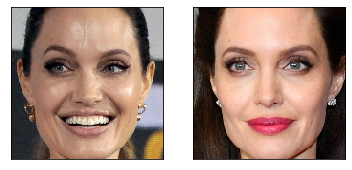

Verified!!!
They are same person.
Euclidean Distance (l2 Norm):  0.5906731
Cosine Similarity:  0.8255525


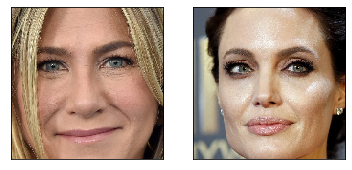

Unverified!!
They are different person
Euclidean Distance (l2 Norm):  1.1376158
Cosine Similarity:  0.35291505


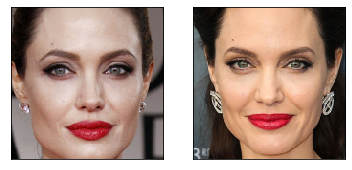

Verified!!!
They are same person.
Euclidean Distance (l2 Norm):  0.48784828
Cosine Similarity:  0.881002


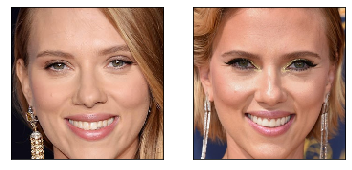

Verified!!!
They are same person.
Euclidean Distance (l2 Norm):  0.53750664
Cosine Similarity:  0.85554343


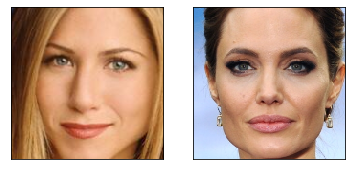

Unverified!!
They are different person
Euclidean Distance (l2 Norm):  1.2348621
Cosine Similarity:  0.23755768


In [67]:
for i in dataset:
    img1_path = i[0]
    img2_path = i[1]
    
    face1 = detect_face(img1_path)
    face2 = detect_face(img2_path)
     
    img1_representation = l2_normalize(model.predict(face1)[0,:])
    img2_representation = l2_normalize(model.predict(face2)[0,:])
    
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    cosine_similarity = CosineSimilarity(model.predict(face1)[0,:], model.predict(face2)[0,:])
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(face1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(face2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    
    if(euclidean_distance < 0.6):
        print("Verified!!!")
        print("They are same person.")
        print("Euclidean Distance (l2 Norm): ", euclidean_distance)
        print("Cosine Similarity: ", cosine_similarity)
        
    else:
        print("Unverified!!")
        print("They are different person")
        print("Euclidean Distance (l2 Norm): ", euclidean_distance)
        print("Cosine Similarity: ", cosine_similarity)